In [1]:
import simulation_settings as ss
import ship as ship
import constants
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import glob
import driver
import time
import datetime
from tqdm.notebook import tqdm, trange
import statistics


In [2]:
gg = constants.gg
rho = constants.rho
beta = constants.beta
dt = constants.dt

In [3]:
#reset variables
if('ww' in globals()):del ww
if('pp' in globals()):del pp
if('dd' in globals()):del dd

In [4]:
scaling = 25/3.11

In [7]:
#create environment JONSWAP(num_waves, T_1, H_third)
T_1 = 2.8
H_3 = 0.3
ww = ss.JONSWAP(100,T_1,H_3)
# ww = ss.Water(H_3, 2*math.pi/T_1)
# print(T_1/math.sqrt(scale))
# print(H_3/scale)

0.07853981633974483


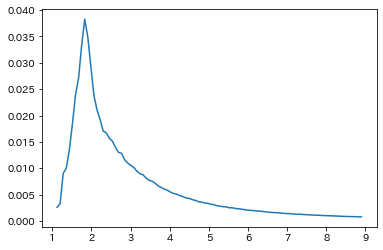

In [8]:
if(type(ww) == ss.JONSWAP):
    x=np.arange(ww.min_omega ,ww.min_omega+ww.N*ww.delta_omega,ww.delta_omega)
    wl=[]
    amp=[]

    for i in range(ww.N):
        amp.append(ww.waves[i].amp)
        wl.append(ww.waves[i].length)

    # plt.plot(x,wl)
    # plt.axhline(y=3.11)
    plt.plot(x,amp)

    print(ww.delta_omega)

In [17]:
####################################
# Max Speed -> 3.5m/s (10m/s @ real scale)
# Target Low Speed -> 0.35m/s(simulation scale; 1m/s @ real scale)
# Refer to scaling.ipynb
####################################
start_time = time.perf_counter()

power=['engine','motor']
props=['fpp','cpp']
power_type = power[0]
prop_type = props[1]

# IMU_en = True

# q = np.array([[10**3, 0], [0, 10**8]])

pp = ship.Ship2(power_type,prop_type)


t=0.0
min = 0
sec = 10
num = (min*60+sec)*1000

dl = []
xl = []
xvl = []
xvl_int = []
xal = []
zl = [] 
zvl= []
zal =[]
eng = []
pl = []
pvl=[]
IMU_ax = []
IMU_az = []
IMU_ry = []
rev=[]
t_rev=[]
wil = []
fl = []
tfl=[]

fxl=[]

PID_vel_err=[]
PID_acc_err=[]
PID_err=[]

PID_curr=[]
PID_targ=[]
PID_star=[]

fps = 50
limit = round(round(1./dt)/fps)

filename = f'T{T_1}_H{H_3}_{power_type},{prop_type}'
# with open(f'{filename}.csv', 'a') as the_file:
#         the_file.write('time,posx,posz,velx,velz,accx,accz,pitch,draught,force\n')

fileList = glob.glob('./output/*.png')
for filePath in fileList:
    try:
        os.remove(filePath)
    except:
        print("Error while deleting file : ", filePath)

filenamecount = 0
velx_int = 0

for i in trange(num):
    pp.update(ww,t)

    if(i%1==0):
       
        # dl.append(pp.draught)
        # xl.append(pp.posx)
        # xvl.append(pp.velx)
        # xal.append(pp.accx)
        # zl.append(pp.posz)
        # zvl.append(pp.velz)
        # zal.append(pp.accz)
        # # wil.append(pp.wave_incline)
        # pl.append(pp.angle*(180/math.pi))
        # # pvl.append(pp.anglevel*(180/math.pi))
        # fl.append(pp.thr_f)
        # tfl.append(pp.target_thr_f)
        # IMU_ax.append(pp.IMU_accx)
        # IMU_az.append(pp.IMU_accz)
        # IMU_ry.append(pp.IMU_roty)
        # rev.append(pp.prop_rev)
        # t_rev.append(pp.P_target_val*pp.P_target_max)
        # xvl_int.append(velx_int)
        # PID_acc_err.append(pp.P_acc_err)
        # PID_vel_err.append(pp.P_vel_err)
        # PID_err.append(pp.P_err)
        # PID_curr.append(pp.P_current_val)
        # PID_star.append(pp.P_start_val)
        # PID_targ.append(pp.P_target_val)
        # fxl.append(pp.fxl)



        with open(f'{filename}.csv', 'a') as the_file:
            the_file.write(f'{t},{pp.posx}, {pp.posz}, {pp.velx}, {pp.velz}, {pp.accx}, {pp.accz}, {pp.angle}, {pp.draught}, {pp.thr_f}\n')


        # graph
        if(i%limit==0):
            xdata = np.arange(-4,8,0.05)
            ydata = np.array([ww.get(x,t) for x in xdata])
            fig, ax = plt.subplots()
            fig.set_facecolor('white')
            ax.set_xlim(-4.0,8.0)
            ax.set_ylim(-1,1)
            ax.plot(xdata,ydata)
            # ax.scatter(pp.posx,pp.posz,s=10)
            
            ts = ax.transData
            coords = ts.transform([pp.posx,pp.posz])
            tr = mpl.transforms.Affine2D().rotate_around(coords[0], coords[1], pp.angle)
            tt = ts + tr
            rec0 = patches.Rectangle((pp.posx-pp.pl/2,pp.posz-pp.ph),pp.pl,pp.ph,linewidth=1,edgecolor='r',facecolor='none', transform=tt)
            ax.add_patch(rec0)
            
            # ax.arrow(pp.posx,pp.posz,pp.posx+pp.accx/10,pp.posz+pp.accz/10)

            # for i in range(len(pp.fxl)):
            #     if(i%10 ==0) : ax.arrow(pp.posx,pp.posz,pp.posx+pp.fxl[i]/50,pp.posz+pp.fzl[i]/100)

            ax.text(-1.5,0.6,f"Velx = {pp.velx*math.sqrt(scaling):.2f}[m/s]")

            ax.set_aspect('equal', adjustable='box')

            ax.set_title(f'Wave Profile T_1 = {T_1*math.sqrt(scaling):.2f}[s], H_1/3 = {H_3*scaling:.2f}[m], t = {round(t):02d}[s]')
            fig.savefig("./output/"+f"{filenamecount:04d}.png")
            plt.clf()
            plt.close()
            filenamecount += 1
    t+=dt
    


# os.system(f'ffmpeg -y -r {fps} -f image2 -i ./output/%04d.png -vcodec libx264 -pix_fmt yuv420p ./video/PID_T{T_1}_H{H_3}_F{force}_V{target_vel}.mp4')
os.system("ffmpeg -y -r 50 -f image2 -i ./output/%04d.png -vcodec libx264 -pix_fmt yuv420p ./video/test.mp4")
end_time = time.perf_counter()

print(end_time-start_time)

  0%|          | 0/10000 [00:00<?, ?it/s]

28411916
-2.2684609398400166
-2.2546240489339167
-2.2407449641730053
-2.2268238948213614
-2.212861050927583
-2.1988566433241297
-2.184810883627168
-2.170723984236164
-2.156596158333399
-2.1424276198836743
-2.1282185836338128
-2.113969265112323
-2.099679880629033
-2.0853506472744736
-2.0709817829196453
-2.056573506215506
-2.0421260365925056
-2.0276395942601795
-2.0131144002066925
-1.9985506761982728
-1.983948644778857
-1.9693085292696115
-1.9546305537683155
-1.9399149431489848
-1.9251619230612662
-1.9103717199301449
-1.8955445609550452
-1.880680674109648
-1.8657802881411978
-1.8508436325699011
-1.8358709376885434
-1.8208624345617426
-1.8058183550254723
-1.7907389316864744
-1.7756243979216348
-1.76047498787738
-1.7452909364691327
-1.7300724793805362
-1.714819853063021
-1.6995332947350046
-1.6842130423813646
-1.6688593347526164
-1.6534724113643664
-1.6380525124967
-1.622599879193305
-1.6071147532608117
-1.591597377268204
-1.576047994546011
-1.560466849185513
-1.5448541860380902
-1.5292102

In [9]:
hsl = []
for i, val in enumerate(xvl):
    hsl.append(val*fl[i])

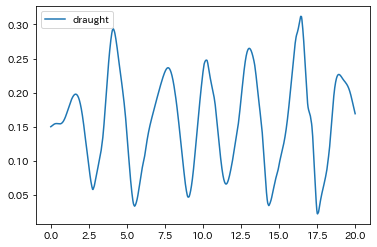

In [10]:
fig, ax = plt.subplots()
tdata = np.arange(0,num*dt,dt)
# ax.set_ylim(-0.5,0.5)
# ax.plot(tdata,xl,label="pos")
# ax.plot(tdata,zvl,label="vel")
# ax.plot(tdata,zal,label="acc")
ax.plot(tdata,dl,label="draught")
# ax.plot(tdata,eng,label="energy")
# ax.plot(tdata,pl,label="pitch angle")
# ax.plot(xl,zl)

# ax.plot(tdata,xvl,label="vel")

ax.legend()

In [15]:
df = pd.read_csv("T2.8_H0.3_engine,cpp.csv")
tdata = df['time']
xl = df['posx']
zl = df['posz']
xvl = df['velx']
xal = df['accx']
zal = df['accz']
pl = df['pitch']
fl = df['force']
dl = df['draught']




0.25186527564608785 -4.879425797364e-05
-516178.10395262565


Text(0, 0.5, 'Pitch angle[deg]')

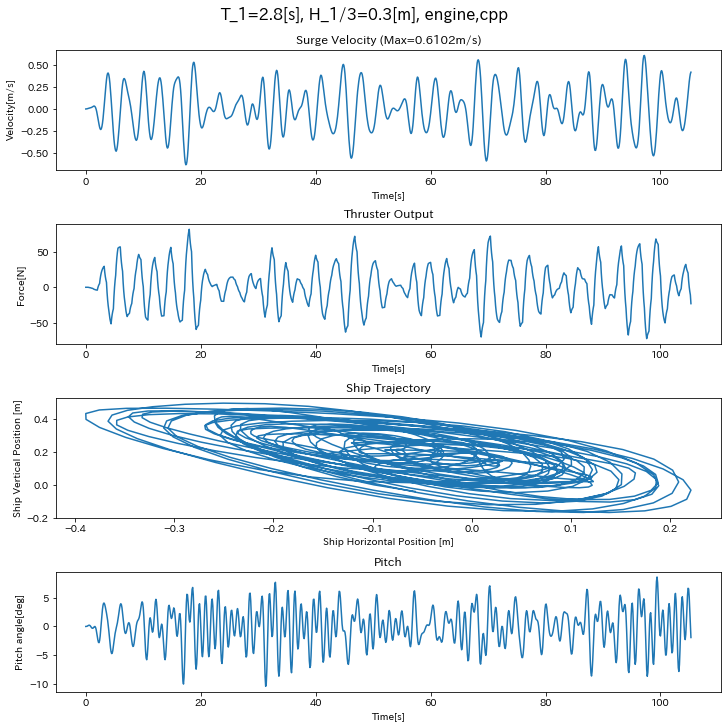

In [30]:
import statistics
xvl_trunc = xvl[-round(len(xvl)/2):]
stdev = statistics.stdev(xvl_trunc)
mean = statistics.mean(xvl_trunc)
cv = stdev/mean*100
print(stdev,mean)
print(cv)



fig, (ax_xvel, ax_thr, ax_pos, ax_pitch) = plt.subplots(nrows=4,figsize=(10,10),constrained_layout=True)


fig.suptitle( f'T_1={T_1}[s], H_1/3={H_3}[m], {power_type},{prop_type}' , fontsize=16)
fig.set_facecolor('white')

ax_xvel.plot(tdata,xvl)
# ax_xvel.plot(tdata,xvl_int)
ax_xvel.set_title(f'Surge Velocity (Max={max(xvl):.4f}m/s)')
ax_xvel.set_xlabel('Time[s]')
ax_xvel.set_ylabel('Velocity[m/s]')

# ax_xvel.text(1,0.15, f'P Coeff:{P_coeff}')
# ax_xvel.text(1,0.1,f'Coeff of Variance:{cv:.04f}%')

# ax_rev.plot(tdata,prop_pitch)
# ax_rev.plot(tdata,t_prop_pitch)
# ax_rev.set_title('prop angle')

ax_thr.plot(tdata,fl)
# ax_thr.plot(tdata,hsl)
ax_thr.set_title('Thruster Output')
ax_thr.set_xlabel('Time[s]')
ax_thr.set_ylabel('Force[N]')


ax_pos.plot(xl,zl)
ax_pos.set_title('Ship Trajectory')
ax_pos.set_xlabel('Ship Horizontal Position [m]')
ax_pos.set_ylabel('Ship Vertical Position [m]')


ax_pitch.plot(tdata,[x*180/math.pi for x in pl])
# ax_pitch.plot(tdata,wil)
ax_pitch.set_title('Pitch')
ax_pitch.set_xlabel('Time[s]')
ax_pitch.set_ylabel('Pitch angle[deg]')


# ax_accx.plot(tdata,xal)
# # ax_accx.plot(tdata,IMU_ax)
# ax_accx.set_title('accx')
# ax_xvel.set_xlabel('Time[s]')


# ax_accz.plot(tdata,zal)
# # ax_accz.plot(tdata,IMU_az)
# ax_accz.set_title('accz')
# ax_xvel.set_xlabel('Time[s]')


# fig.savefig("./figures/"+f"{filename}-{time.time()}.png")

Text(0, 0.5, 'Occurences (with dt = 0.1s)')

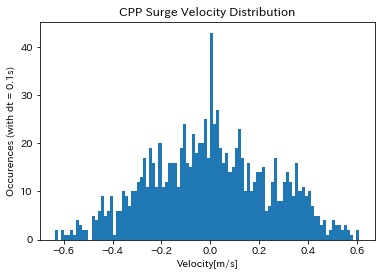

In [27]:
plt.hist(xvl,bins=100)
plt.title('CPP Surge Velocity Distribution')
plt.xlabel('Velocity[m/s]')
plt.ylabel('Occurences (with dt = 0.1s)')

Text(0, 0.5, 'Occurences (with dt = 0.1s)')

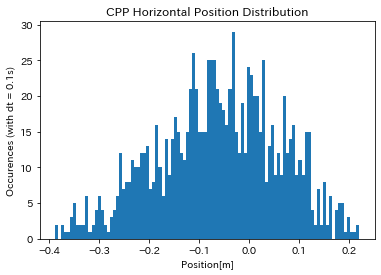

In [28]:
plt.hist(xl,bins=100)
plt.title('CPP Horizontal Position Distribution')
plt.xlabel('Position[m]')
plt.ylabel('Occurences (with dt = 0.1s)')

{'whiskers': [<matplotlib.lines.Line2D at 0x1ad68c8d278>,
 'caps': [<matplotlib.lines.Line2D at 0x1ad6929f978>,
 'boxes': [<matplotlib.lines.Line2D at 0x1ad692a7588>],
 'medians': [<matplotlib.lines.Line2D at 0x1ad68e682b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1ad68d24ac8>],
 'means': []}

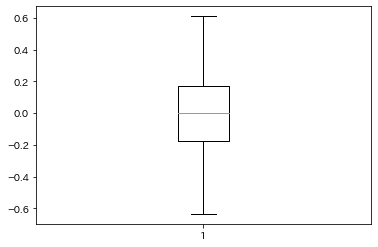

In [31]:
plt.boxplot(xvl)

In [12]:
wave = ww.waves[0]
z= 0
d_c = wave.omega * wave.k * wave.amp**2 * math.exp(2*wave.k*z)
d_e = statistics.mean(xvl[-round(len(xvl)*0.2):])

drift_calc.append(d_c)
drift_exp.append(d_e)
period.append(wave.period)

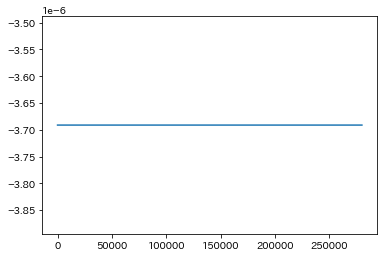

In [13]:
w = 300000
ma = np.convolve(xvl, np.ones(w), 'valid') / w
plt.plot(ma)

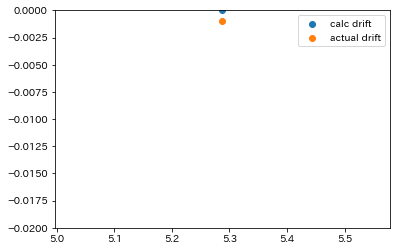

In [14]:
plt.scatter(period, [-x for x in drift_calc],label='calc drift')
plt.scatter(period,drift_exp,label='actual drift')
plt.ylim(-0.02,0)
plt.legend()